In [1]:
%load_ext autoreload
%autoreload 2

# first we need a bit of import boilerplate
import os
import sys
from sys import platform
if platform == 'win32':
    sys.path.append('D:/Brain_Network/Code/')
    manifest_path = 'D:\Brain_Network\Data\Allen_Institute_Dataset/manifest.json'
elif platform=='darwin':
    sys.path.append('/Users/chenyu/Workspace/Brain_Network/Code/')
    manifest_path = '/Users/chenyu/Workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
else:
    print('Add new computer system settings.')

import numpy as np; np.set_printoptions(linewidth=110); print(np.get_printoptions()['linewidth'])
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn
import scipy
import scipy.io as sio
from scipy.ndimage.filters import gaussian_filter
import seaborn
from tqdm.notebook import trange
import time

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import (
    EcephysSession, 
    removed_unused_stimulus_presentation_columns
)
from allensdk.brain_observatory.ecephys.visualization import (
    plot_mean_waveforms, 
    plot_spike_counts, 
    raster_plot)
from allensdk.brain_observatory.visualization import plot_running_speed

# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

import data_visualizer
import data_model
import hierarchical_model
import hierarchical_sampling_model
import util
import smoothing_spline

110
Download time: 291600


In [2]:
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)
session_id = 791319847  # 715093703 791319847 754829445 771990200
session = cache.get_session_data(session_id)


Download time: 291600


# Extract data from multiple brain areas

# Hierarchical model inference

In [10]:
# model = data_model.AllenInstituteDataModel(session)
# model = hierarchical_model.HierarchicalModel(session)
model = hierarchical_sampling_model.HierarchicalSamplingModel(session)

### Select neurons by regions

In [6]:
probes = ['probeC', 'probeE']
selected_units = session.units[
    session.units['ecephys_structure_acronym'].isin(util.VISUAL_AREA) & 
    session.units['probe_description'].isin(probes)]

display(selected_units.shape)
display(selected_units[selected_units['probe_description'] == probes[0]].shape)
display(selected_units[selected_units['probe_description'] == probes[1]].shape)
# display(selected_units.head())


(136, 89)

(93, 89)

(43, 89)

## Select conditions

drifting_gratings

In [7]:
orientation = [270, ]  # 'null'
temporal_frequency = [8, ]  # 'null'
stimulus_table = session.get_stimulus_table(['drifting_gratings'])
trials_indices = stimulus_table[
    stimulus_table['orientation'].isin(orientation) & 
    stimulus_table['temporal_frequency'].isin(temporal_frequency)].index.values
print('num trials:', len(trials_indices))

num trials: 15


drfting_gratings_contrast

In [1241]:
orientation = [225.,]
contrast = [0.13,]
stimulus_table = session.get_stimulus_table(['drifting_gratings_contrast'])
trials_indices = stimulus_table[
    stimulus_table['orientation'].isin(orientation) & 
    stimulus_table['contrast'].isin(contrast)].index.values
print('num trials:', len(trials_indices))

num trials: 15


flashes

In [1070]:
stimulus_table = session.get_stimulus_table(['flashes'])
trials_indices = stimulus_table.index.values[:30]
print('num trials:', len(trials_indices))

num trials: 30


### Get spike trains.

In [8]:
trial_time_window=[0.0, 0.5]
dt=0.002
spike_train_time_line = np.arange(trial_time_window[0], trial_time_window[1], dt)

spike_trains = model.get_trial_metric_per_unit_per_trial(
        stimulus_presentation_ids=trials_indices,
        unit_ids=selected_units.index.values,
        trial_time_window=trial_time_window,
        metric_type='spike_trains',
        dt=dt)

display(spike_trains.shape)
# display(spike_trains.head())

spike_times = model.get_trial_metric_per_unit_per_trial(
        stimulus_presentation_ids=trials_indices,
        unit_ids=selected_units.index.values,
        trial_time_window=trial_time_window,
        metric_type='spike_times')

display(spike_times.shape)

AttributeError: 'NoneType' object has no attribute '_filter_owned_df'

# Visualize the data.

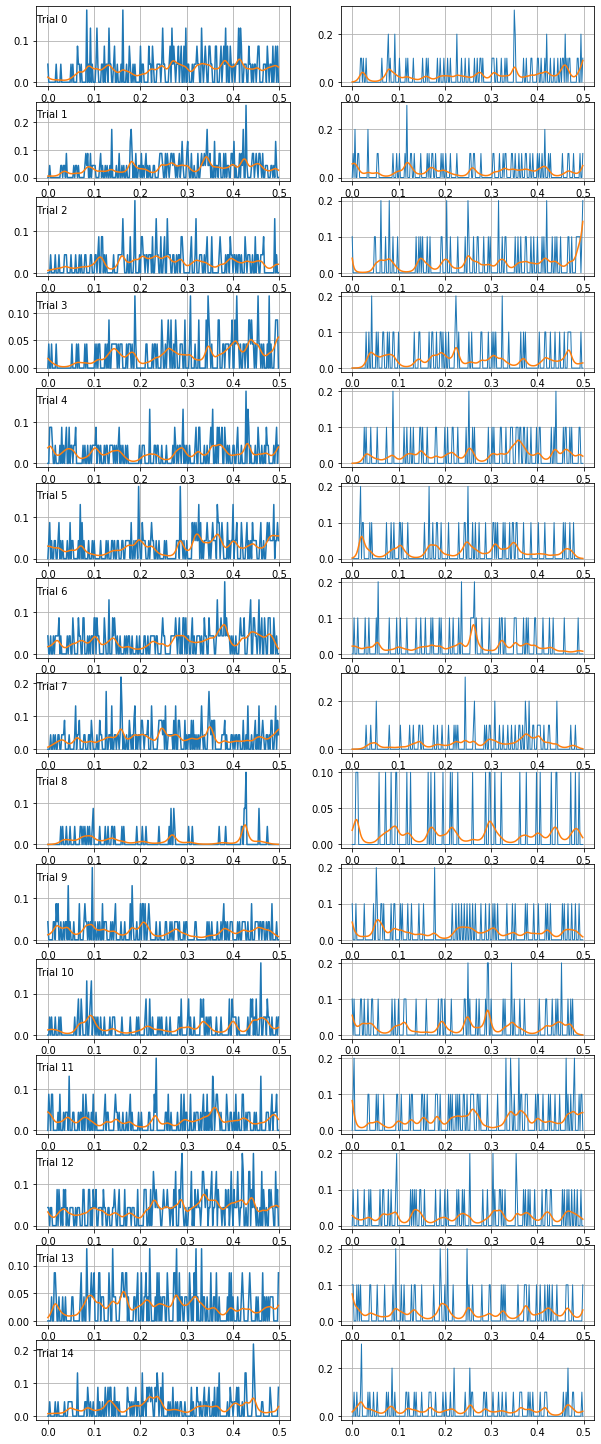

In [1173]:
model.plot_group_intensity_per_trial(spike_trains, spike_train_time_line, trials_indices, probes)


## Main sampling loop.

In [74]:
np.random.seed(0)
model = hierarchical_sampling_model.HierarchicalSamplingModel(session)
model.initial_step(spike_trains, spike_train_time_line,
                   selected_units, trials_indices, trial_time_window, probes, spike_times,
                   model_feature_type='BSS', eta_smooth_tuning=1e-8, verbose=False)

Model feature type:  BSS
Area probeC.
2    59
0    19
1    15
Name: group_id, dtype: int64
Area probeE.
2    27
0     9
1     7
Name: group_id, dtype: int64


In [126]:
model.group_activity_statistic(probes, trials_indices, spike_train_time_line)

Area probeC.
2    59
0    19
1    15
Name: group_id, dtype: int64
Area probeE.
2    27
0     9
1     7
Name: group_id, dtype: int64
Group id: 0  SCC: 0.3839076935942994  SFTC: 0.13668545232401935
Group id: 2  SCC: 0.5135276571058731  SFTC: 0.17455595578320965
Group id: 1  SCC: 0.7218303178318346  SFTC: 0.25047276779910993


In [75]:
t = trange(0, 700)
for itr in t:
    model.update_f_local_pop_gac(spike_trains, spike_train_time_line, probes, trials_indices,
                                 verbose=False)
    model.update_f_cross_pop_ac(spike_trains, spike_train_time_line, probes, trials_indices, spike_times,
                                separate_fitting=True, verbose=False)
#     model.update_f_cross_local_pop_ac(spike_trains, spike_train_time_line, probes, trials_indices, spike_times,
#                                       verbose=False)
    if itr < 50:
        model.update_q_arc(spike_trains, spike_train_time_line, probes, trials_indices,
                           sample_type='fit', verbose=False)
    if itr >= 50:
        model.update_q_arc(spike_trains, spike_train_time_line, probes, trials_indices,
                           sample_type='sample', proposal_scalar=0.05, verbose=False)
    if itr >= 60:
        model.update_mu_simga(sample_type='sample', verbose=False)

    if itr > 20:
        model.update_z_ngac(spike_trains, spike_train_time_line, probes, trials_indices, 
                            sample_type='sample', verbose=False)
        model.update_p_ac(probes, sample_type='sample', verbose=False)

    model.complete_log_likelihood(spike_trains, spike_train_time_line, trials_indices, probes)
    t.set_description(f'log-likelihood: {model.samples.log_likelihood[-1]:.2f}')


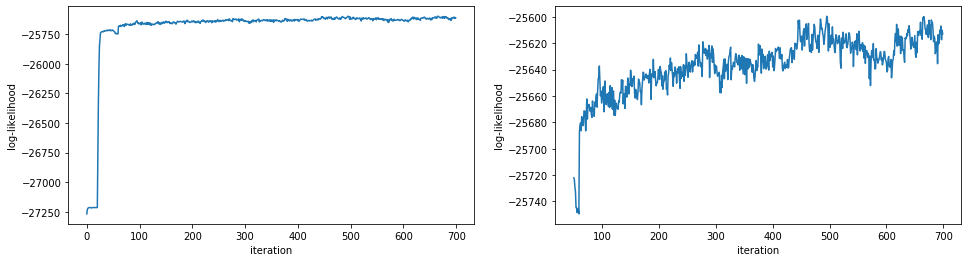

f_pop: 700
q: 700
q_shift1: 700
q_shift2: 700
mu_cross_pop: 0
sigma_cross_pop: 640
z: 679
p: 679
log_likelihood: 700


In [76]:
model.samples.plot_log_likelihood()
model.samples.peek()

# Save / Load results.

In [77]:
experiment_name = '0-500ms_BSS_o270_f8_'
timestr = time.strftime("%Y%m%d-%H%M%S")
prefix = 'hierarchical_bayesian_sampling_model_'
# output_folder = '/Users/chenyu/Workspace/Brain_Network/test/'
output_folder = 'D:/Brain_Network/test/'
file_path = output_folder + prefix + experiment_name + timestr + '.pkl'
print(file_path)
model.samples.save(file_path)

D:/Brain_Network/test/hierarchical_bayesian_sampling_model_0-500ms_BSS_o270_f8_20200621-210044.pkl
Save file to: D:/Brain_Network/test/hierarchical_bayesian_sampling_model_0-500ms_BSS_o270_f8_20200621-210044.pkl


In [1037]:
output_folder = '/Users/chenyu/Workspace/Brain_Network/test/'
file_path = (output_folder + 
    'hierarchical_bayesian_sampling_model_0-500ms_BSS_20200608-170018.pkl')
model.samples.load(file_path)
# model.samples.clear_samples_memory()

Load file from: /Users/chenyu/Workspace/Brain_Network/test/hierarchical_bayesian_sampling_model_0-500ms_BSS_20200608-170018.pkl


### q_arc

Accept ratio: 0.544820512820512    Number of samples (for each trial): 9750
num_qs: 15
(700, 2, 15, 1)
Area 1


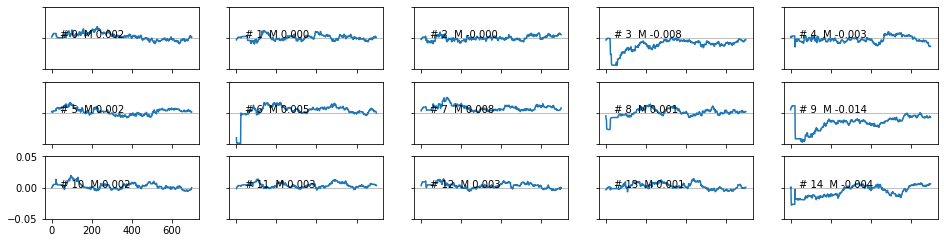

Area 2


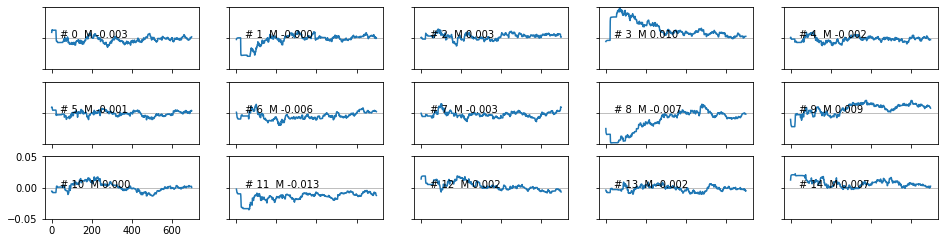

In [70]:
# model.samples.plot_q_arc(option='q')
model.samples.plot_q_arc(option='q_shift1')
# model.samples.plot_q_arc(option='q_shift2')

### mu sigma rho

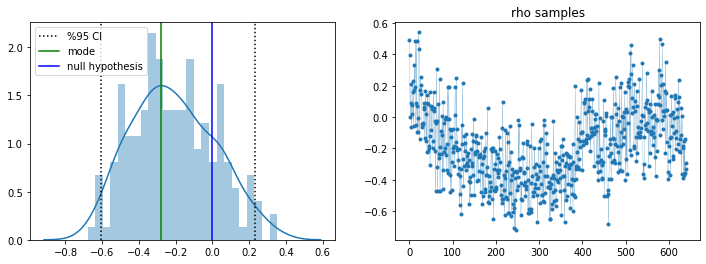

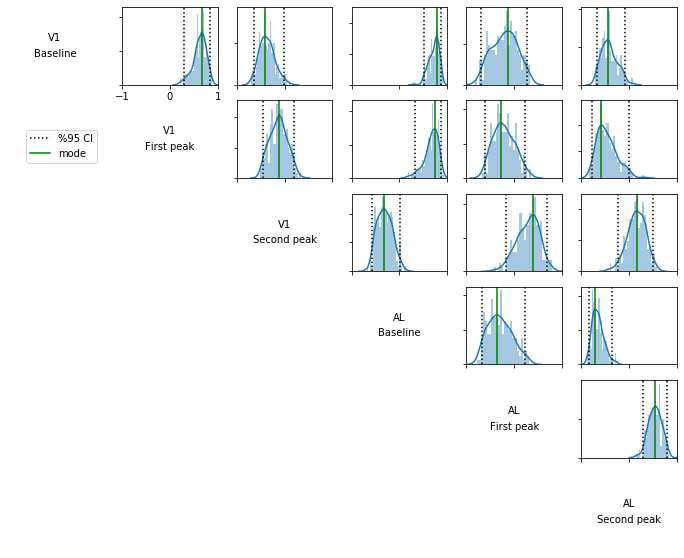

In [82]:
model.samples.plot_mu_sigma_rho(1, 4, burn_in=100, end=-1, step=3, show_whole_panel=True)

### f_pop

(60, 1, 2, 3, 250)


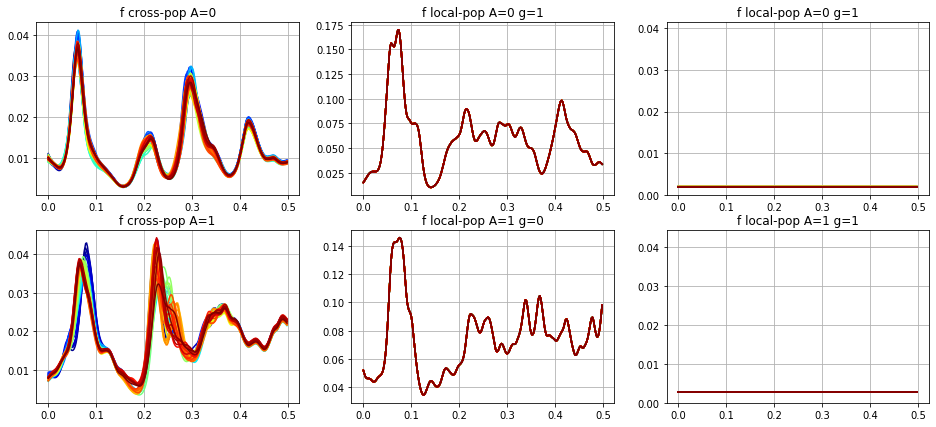

In [79]:
# model.plot_f_pop(spike_train_time_line)
# model.samples.plot_f_pop_mean(burn_in=100, step=5)
model.samples.plot_f_pop(burn_in=100, step=10)


##  z_ngarc

Area probeC.
2    57
0    31
1     5
Name: group_id, dtype: int64
Area probeE.
2    25
0    14
1     4
Name: group_id, dtype: int64
Group id: 0  SCC: 0.8316568408394973  SFTC: 0.06253368879117158
Group id: 1  SCC: 0.8902775569164302  SFTC: -0.21950400075472098
Group id: 2  SCC: -0.2358279710325374  SFTC: 0.3746290237553303


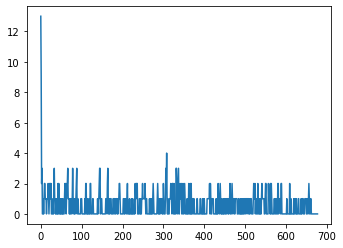

In [81]:
model.group_activity_statistic(probes, trials_indices, spike_train_time_line)
model.samples.plot_z_ngarc()

## p_ac

p_gac mean: [0.3370462  0.09372442 0.56922937]
p_gac mean: [0.32556729 0.15519624 0.51923647]


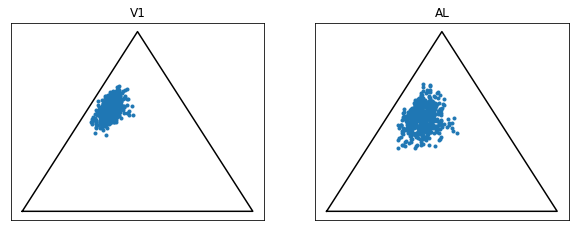

In [80]:
model.samples.plot_p_gac(burn_in=100, step=1)
